# Creating a frequency finder auto-encoder

## Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plttest
from tensorflow.keras import callbacks
import tensorflow.keras as keras
from tensorflow.keras import layers
import umap
from babyplots import Babyplot
#import hdbscan
from matplotlib import pyplot
from models import *
from converters import *
from helpers import *
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

2021-10-07 13:40:45.962738: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-07 13:40:45.962756: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%load_ext autoreload
%autoreload 2

## Load Data from drive

In [3]:
try:
    drive_path = find_drive_path()
    data = pd.read_pickle(f"{drive_path}/Data/Inputs/Synthetisch/Syn_tot.pkl")
except:
    data = pd.read_pickle("../../Data/Syn01_02.pkl")
data.head()

,IID,Pheno,Geno,State
0,0pop1,1,"[2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, ...",pop1sick
1,1pop1,1,"[2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, ...",pop1sick
2,2pop1,1,"[2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, ...",pop1sick
3,3pop1,0,"[2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",pop1healthy
4,4pop1,1,"[2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, ...",pop1sick


In [4]:
data.tail()

,IID,Pheno,Geno,State
1995,995pop2,0,"[2, 0, 0, 0, 1, 2, 2, 2, 1, 0, 1, 0, 2, 1, 1, ...",pop2healthy
1996,996pop2,0,"[1, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 2, 1, 0, ...",pop2healthy
1997,997pop2,0,"[1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 1, 1, 2, 1, 2, ...",pop2healthy
1998,998pop2,0,"[2, 2, 1, 2, 0, 1, 0, 2, 0, 1, 0, 2, 2, 0, 0, ...",pop2healthy
1999,999pop2,0,"[1, 0, 1, 1, 2, 1, 1, 0, 0, 0, 2, 1, 1, 1, 1, ...",pop2healthy


## Preprocessing data into tensors 

### Keeping only the minor alleles as 1

In [5]:
X = only_minor(data["Geno"])
y = data["Pheno"]
y

0       1
1       1
2       1
3       0
4       1
       ..
1995    0
1996    0
1997    0
1998    0
1999    0
Name: Pheno, Length: 2000, dtype: int64

### Train test split

In [6]:
split = splitter([X,y],0.1)
[X_train, X_test, y_train, y_test] = tensor_converter(split)
X = tensor_converter(X)
y = tensor_converter(y)
X = tf.stack(X, axis = 0)
y = tf.stack(y, axis = 0)

2021-10-07 13:40:50.538766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 13:40:50.539103: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-07 13:40:50.539154: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-10-07 13:40:50.539215: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-10-07 13:40:50.540685: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

## Model 1

### Loading hyper-parameters

In [7]:
BATCH_SIZE = 64
WEIGHT_DECAY = 0.001
PRUNING = 0.5
LEARNING_RATE = 0.01
first_layer = 200
second_layer = 46

### Building the model

In [8]:
input_len = int(tf.shape(X_train)[1])
AE = AutoEncoder(input_len, first_layer, second_layer)
AE.build((None, input_len))

### Training the model with a bottleneck of 46

In [9]:
checkpoint_path = "../../Data/"
es = callbacks.EarlyStopping(patience=30, restore_best_weights=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*BATCH_SIZE)
AE.save_weights(checkpoint_path.format(epoch=0))
AE.compile(
    optimizer = keras.optimizers.Adam(LEARNING_RATE),
    loss = "BinaryCrossentropy",
    metrics = ["BinaryAccuracy"])

autoencoder_model = AE.fit(X_train, 
          X_train, 
          validation_data=(X_test, X_test),
          epochs = 150,
          callbacks=[es,cp_callback],
          verbose = 1)

2021-10-07 13:40:51.107813: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150








56/57 [============================>.] - ETA: 0s - loss: 6.3016 - binary_accuracy: 0.5831



57/57 [==============================] - 2s 28ms/step - loss: 6.3020 - binary_accuracy: 0.5831 - val_loss: 6.3539 - val_binary_accuracy: 0.5849
Epoch 2/150
57/57 [==============================] - 1s 24ms/step - loss: 6.3443 - binary_accuracy: 0.5856 - val_loss: 6.3519 - val_binary_accuracy: 0.5851
Epoch 3/150
57/57 [==============================] - 1s 23ms/step - loss: 6.3445 - binary_accuracy: 0.5856 - val_loss: 6.3510 - val_binary_accuracy: 0.5851
Epoch 4/150
57/57 [==============================] - 1s 24ms/step - loss: 6.3439 - binary_accuracy: 0.5856 - val_loss: 6.3493 - val_binary_accuracy: 0.5853
Epoch 5/150
57/57 [==============================] - 1s 24ms/step - loss: 6.3425 - binary_accuracy: 0.5857 - val_loss: 6.3493 - val_binary_accuracy: 0.5853
Epoch 6/150
35/57 [=================>............] - ETA: 0s - loss: 6.3418 - binary_accuracy: 0.5857
Epoch 00006: savi

### Plotting metrics

<module 'matplotlib.pyplot' from '/home/mat2m10/.pyenv/versions/3.8.12/envs/ctg/lib/python3.8/site-packages/matplotlib/pyplot.py'>

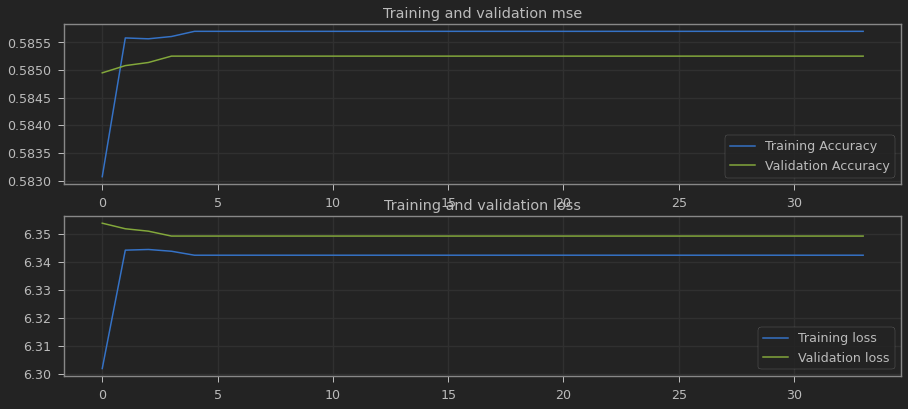

In [10]:
metrics_viewer(autoencoder_model)

### Extracting values of bottleneck

In [11]:
hidden_repr = AE.layers[0](X)

### Visualization in 3D

In [12]:
reducer = umap.UMAP(random_state = 42)
reducer.fit(hidden_repr)
embedding = reducer.transform(hidden_repr)
reducer3d = umap.UMAP(random_state = 42, n_components = 3)
reducer3d.fit(hidden_repr)
embedding3d = reducer3d.transform(hidden_repr)

In [13]:
labels = color_label_maker(hidden_repr,2)

In [14]:
bp = Babyplot()
#"customColorScale": "Dark2", "Paired", "Viridis", "Set2"
bp.add_plot(embedding3d.tolist(), "pointCloud",
           "categories", labels, {
               "size": 1.5,
               "colorScale":"custom",
               "customColorScale": "Paired",
               "folded": True,
               "showLegend": True,
               "legendTitle": "Population",
               "legendTitleFontSize": 20,
               "legendTitleFontColor":"#93c273",
               "fontColor": "#60AFEF",
               "fontSize": 15,
               "foldedEmbedding": embedding.tolist(),
           })
bp.background_color = "#2b5480"
#bp.show_ui = True
bp

<IPython.core.display.Javascript object>

## Model 2

### Loading hyper

In [15]:
BATCH_SIZE = 64
WEIGHT_DECAY = 0.001
PRUNING = 0.5
LEARNING_RATE = 0.01
first_layer = 200
second_layer = 1

### Building model

In [163]:
input_len = int(tf.shape(X_train)[1])
AE = AutoEncoder(input_len, first_layer, second_layer)
AE.build((None, input_len))

### Training model with bottleneck of 1

In [164]:
checkpoint_path = "../../Data/"
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*BATCH_SIZE)
AE.save_weights(checkpoint_path.format(epoch=0))
AE.compile(
    optimizer = keras.optimizers.Adam(LEARNING_RATE),
    loss = "BinaryCrossentropy",
    metrics = ["BinaryAccuracy"])

autoencoder_model = AE.fit(X_train, 
          X_train, 
          validation_data=(X_test, X_test),
          epochs = 100,
          callbacks=[es,cp_callback],
          verbose = 1)

Epoch 1/100








56/57 [============================>.] - ETA: 0s - loss: 7.8405 - binary_accuracy: 0.4846



57/57 [==============================] - 2s 27ms/step - loss: 7.8413 - binary_accuracy: 0.4845 - val_loss: 8.0734 - val_binary_accuracy: 0.4717
Epoch 2/100
57/57 [==============================] - 1s 25ms/step - loss: 8.1231 - binary_accuracy: 0.4683 - val_loss: 8.1930 - val_binary_accuracy: 0.4637
Epoch 3/100
57/57 [==============================] - 1s 25ms/step - loss: 8.2574 - binary_accuracy: 0.4594 - val_loss: 8.3245 - val_binary_accuracy: 0.4551
Epoch 4/100
57/57 [==============================] - 1s 25ms/step - loss: 8.3608 - binary_accuracy: 0.4527 - val_loss: 8.4039 - val_binary_accuracy: 0.4499
Epoch 5/100
57/57 [==============================] - 1s 25ms/step - loss: 8.3986 - binary_accuracy: 0.4503 - val_loss: 8.4062 - val_binary_accuracy: 0.4498
Epoch 6/100
33/57 [================>.............] - ETA: 0s - loss: 8.4094 - binary_accuracy: 0.4495
Epoch 00006: savi

### Plotting metrics

<module 'matplotlib.pyplot' from '/home/mat2m10/.pyenv/versions/3.8.12/envs/ctg/lib/python3.8/site-packages/matplotlib/pyplot.py'>

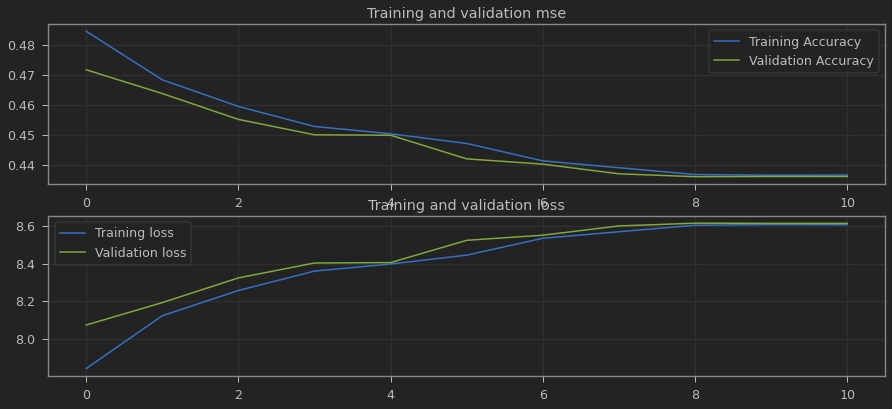

In [165]:
metrics_viewer(autoencoder_model)

### Extracting values of bottleneck

In [166]:
hidden_repr = AE.layers[0](X)

In [167]:
x = np.array(hidden_repr)

In [168]:
x1 = x[0:int(len(x)/2)]
x2 = x[int(len(x)/2):]

In [169]:
x1[:,0]

array([ -960.72217,  -950.9402 ,  -988.124  ,  -939.0448 ,  -953.775  ,
        -957.85474,  -950.2284 ,  -971.1852 ,  -940.02814,  -948.76514,
        -970.6151 ,  -946.09705,  -963.97217,  -935.34436,  -937.4618 ,
        -948.02014,  -949.2019 ,  -982.8053 ,  -964.45154,  -974.16284,
        -945.90375,  -947.09906,  -965.91235,  -937.3858 ,  -926.54114,
        -973.4851 ,  -934.8314 ,  -946.0128 ,  -958.07324,  -984.59656,
        -948.2364 ,  -947.5072 ,  -955.235  ,  -941.9026 ,  -972.3965 ,
        -971.90564,  -944.58466,  -945.2444 ,  -948.1492 ,  -932.22186,
        -953.3303 ,  -940.114  ,  -941.57263,  -956.175  ,  -964.9153 ,
        -950.9298 , -1007.7073 ,  -963.6346 ,  -930.04083,  -961.19666,
        -979.1324 ,  -980.0297 ,  -948.87335,  -975.438  ,  -939.9332 ,
        -987.2834 ,  -965.3538 ,  -948.506  ,  -961.05743,  -941.3055 ,
        -959.1929 ,  -943.70544,  -966.6654 ,  -942.115  ,  -934.29846,
        -951.13525,  -942.3589 ,  -944.6141 ,  -943.90106,  -977

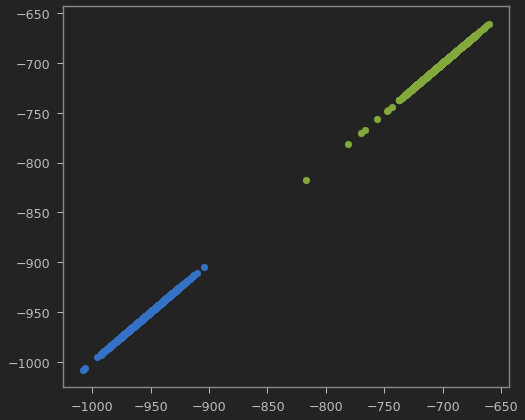

In [170]:
try:
    plt.scatter(x1[:,0], x1[:,1])
    plt.scatter(x2[:,0], x2[:,1])
    plt.show
except:
    plt.scatter(x1, x1)
    plt.scatter(x2, x2)

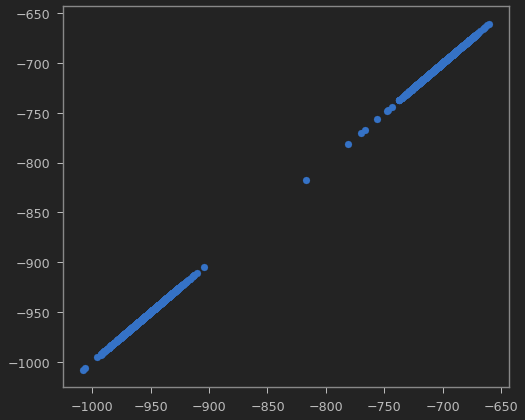

In [171]:
plt.scatter(x, x)

In [172]:
#Import required module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 3)
 
#predict the labels of clusters.
label = kmeans.fit_predict(x)
 
print(label)

[2 0 2 ... 1 1 1]


In [173]:
abs(x)

array([[960.72217],
       [950.9402 ],
       [988.124  ],
       ...,
       [702.045  ],
       [698.633  ],
       [695.4865 ]], dtype=float32)

In [174]:
data["first_component"] = x

In [175]:
data

,IID,Pheno,Geno,State,first_component
0,0pop1,1,"[2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, ...",pop1sick,-960.722168
1,1pop1,1,"[2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, ...",pop1sick,-950.940186
2,2pop1,1,"[2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, ...",pop1sick,-988.124023
3,3pop1,0,"[2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",pop1healthy,-939.044800
4,4pop1,1,"[2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, ...",pop1sick,-953.775024
...,...,...,...,...,...
1995,995pop2,0,"[2, 0, 0, 0, 1, 2, 2, 2, 1, 0, 1, 0, 2, 1, 1, ...",pop2healthy,-685.147705
1996,996pop2,0,"[1, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 2, 1, 0, ...",pop2healthy,-691.982056
1997,997pop2,0,"[1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 1, 1, 2, 1, 2, ...",pop2healthy,-702.044983
1998,998pop2,0,"[2, 2, 1, 2, 0, 1, 0, 2, 0, 1, 0, 2, 2, 0, 0, ...",pop2healthy,-698.632996


In [176]:
data_sorted = data.sort_values(by=['first_component'])
data_sorted

,IID,Pheno,Geno,State,first_component
46,46pop1,1,"[2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",pop1sick,-1007.707275
179,179pop1,0,"[2, 0, 0, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 0, ...",pop1healthy,-1006.497803
837,837pop1,1,"[0, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, ...",pop1sick,-995.650757
619,619pop1,0,"[1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",pop1healthy,-992.695068
78,78pop1,0,"[2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, ...",pop1healthy,-992.615540
...,...,...,...,...,...
1766,766pop2,0,"[2, 1, 1, 0, 1, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, ...",pop2healthy,-665.541016
1792,792pop2,0,"[0, 1, 0, 1, 2, 1, 1, 2, 0, 0, 2, 0, 1, 2, 0, ...",pop2healthy,-665.037537
1511,511pop2,0,"[1, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 1, 0, 2, 1, ...",pop2healthy,-663.821533
1483,483pop2,1,"[1, 1, 2, 0, 1, 1, 1, 2, 1, 1, 0, 0, 0, 1, 0, ...",pop2sick,-662.400818


In [177]:
test = np.array(data_sorted['Geno'].to_list())[:,0] - 1

In [178]:
genos = np.array(data_sorted['Geno'].to_list())
len(genos[0])

10000

In [179]:
genos[:,0] - 1

array([ 1,  1, -1, ...,  0,  0, -1])

In [180]:
major = np.where(test == -1, 0, test)
minor = np.where(test == 1, 0, test)
major

array([1, 1, 0, ..., 0, 0, 0])

In [181]:
minor

array([ 0,  0, -1, ...,  0,  0, -1])

In [182]:
test

array([ 1,  1, -1, ...,  0,  0, -1])

In [183]:
x_axis = np.array(range(0, len(minor), 1))
x_axis

array([   0,    1,    2, ..., 1997, 1998, 1999])

<function matplotlib.pyplot.show(close=None, block=None)>

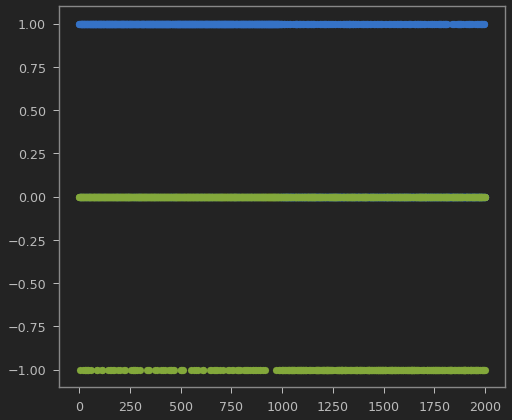

In [184]:
plt.scatter(x_axis, major)
plt.scatter(x_axis, minor)
plt.show

In [185]:
test

array([ 1,  1, -1, ...,  0,  0, -1])

In [186]:
nr_splits = 50

In [187]:
arrays = np.split(test, nr_splits)


In [188]:
array_sums = []
for array in arrays:
    array_sums.append(sum(array)/len(array))
array_sums

[0.575,
 0.725,
 0.725,
 0.775,
 0.7,
 0.75,
 0.575,
 0.75,
 0.725,
 0.775,
 0.825,
 0.525,
 0.775,
 0.875,
 0.725,
 0.75,
 0.65,
 0.775,
 0.775,
 0.5,
 0.7,
 0.675,
 0.7,
 0.95,
 0.625,
 -0.15,
 -0.125,
 -0.2,
 0.15,
 -0.275,
 -0.25,
 -0.125,
 -0.225,
 0.1,
 -0.3,
 -0.125,
 -0.25,
 -0.3,
 -0.3,
 -0.1,
 -0.2,
 -0.15,
 -0.125,
 -0.2,
 -0.075,
 -0.275,
 -0.075,
 -0.3,
 -0.25,
 -0.075]

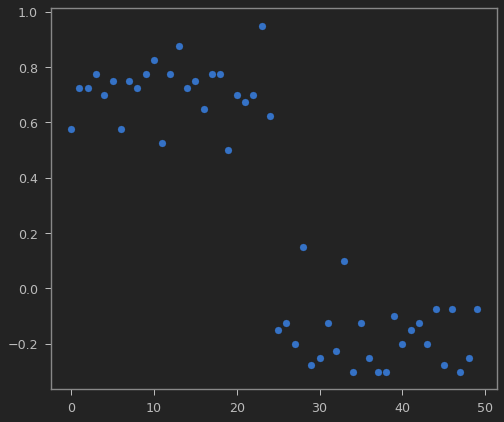

In [189]:
plt.scatter(x_axis[0:nr_splits], array_sums)

In [190]:
p = list(map(lambda x:(x+1)/2, array_sums))
p

[0.7875,
 0.8625,
 0.8625,
 0.8875,
 0.85,
 0.875,
 0.7875,
 0.875,
 0.8625,
 0.8875,
 0.9125,
 0.7625,
 0.8875,
 0.9375,
 0.8625,
 0.875,
 0.825,
 0.8875,
 0.8875,
 0.75,
 0.85,
 0.8375,
 0.85,
 0.975,
 0.8125,
 0.425,
 0.4375,
 0.4,
 0.575,
 0.3625,
 0.375,
 0.4375,
 0.3875,
 0.55,
 0.35,
 0.4375,
 0.375,
 0.35,
 0.35,
 0.45,
 0.4,
 0.425,
 0.4375,
 0.4,
 0.4625,
 0.3625,
 0.4625,
 0.35,
 0.375,
 0.4625]

In [191]:
 1*q + -1*(1-q) = 0.4625
q = list(map(lambda x:1-((x+1)/2), array_sums))
q

[0.21250000000000002,
 0.13749999999999996,
 0.13749999999999996,
 0.11250000000000004,
 0.15000000000000002,
 0.125,
 0.21250000000000002,
 0.125,
 0.13749999999999996,
 0.11250000000000004,
 0.08750000000000002,
 0.23750000000000004,
 0.11250000000000004,
 0.0625,
 0.13749999999999996,
 0.125,
 0.17500000000000004,
 0.11250000000000004,
 0.11250000000000004,
 0.25,
 0.15000000000000002,
 0.16249999999999998,
 0.15000000000000002,
 0.025000000000000022,
 0.1875,
 0.575,
 0.5625,
 0.6,
 0.42500000000000004,
 0.6375,
 0.625,
 0.5625,
 0.6125,
 0.44999999999999996,
 0.65,
 0.5625,
 0.625,
 0.65,
 0.65,
 0.55,
 0.6,
 0.575,
 0.5625,
 0.6,
 0.5375,
 0.6375,
 0.5375,
 0.65,
 0.625,
 0.5375]

In [192]:
x_reduced = x_axis[0:nr_splits]*(x_axis[-1]/nr_splits)

<function matplotlib.pyplot.show(close=None, block=None)>

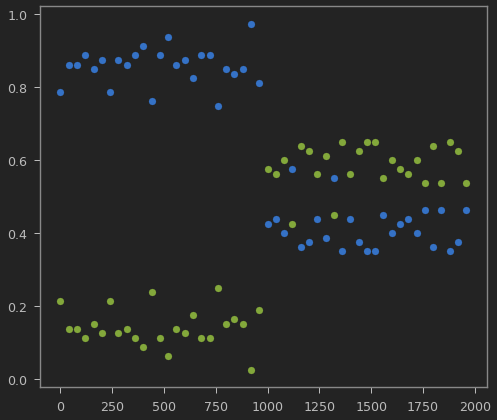

In [193]:
plt.scatter(x_reduced, p)
plt.scatter(x_reduced, q)
plt.show

In [194]:
model = keras.Sequential()
model.add(keras.layers.Dense(units = 1, activation = 'linear', input_shape=[1]))
model.add(keras.layers.Dense(units = 64, activation = 'elu'))
model.add(keras.layers.Dense(units = 64, activation = 'elu'))
model.add(keras.layers.Dense(units = 1, activation = 'linear'))
model.compile(loss='mse', optimizer="adam")

# Display the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_26 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 4,355
Trainable params: 4,355
Non-trainable params: 0
_________________________________________________________________


In [195]:
model.fit( x_reduced, np.array(p), epochs=1000, verbose=1)

Epoch 1/1000
2/2 [==============================] - 0s 2ms/step - loss: 10920.7012
Epoch 2/1000
2/2 [==============================] - 0s 1ms/step - loss: 5916.4927
Epoch 3/1000
2/2 [==============================] - 0s 1ms/step - loss: 2628.3884
Epoch 4/1000
2/2 [==============================] - 0s 2ms/step - loss: 573.3748
Epoch 5/1000
2/2 [==============================] - 0s 1ms/step - loss: 27.0466
Epoch 6/1000
2/2 [==============================] - 0s 2ms/step - loss: 315.6900
Epoch 7/1000
2/2 [==============================] - 0s 1ms/step - loss: 828.5328
Epoch 8/1000
2/2 [==============================] - 0s 1ms/step - loss: 1077.9545
Epoch 9/1000
2/2 [==============================] - 0s 2ms/step - loss: 1026.0002
Epoch 10/1000
2/2 [==============================] - 0s 1ms/step - loss: 735.1972
Epoch 11/1000
2/2 [==============================] - 0s 1ms/step - loss: 412.4848
Epoch 12/1000
2/2 [==============================] - 0s 2ms/step - loss: 177.7361
Epoch 13/1000
2/2 [=

2/2 [==============================] - 0s 1ms/step - loss: 0.0116
Epoch 103/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0122
Epoch 104/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0115
Epoch 105/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0120
Epoch 106/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0121
Epoch 107/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0118
Epoch 108/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0117
Epoch 109/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0114
Epoch 110/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0120
Epoch 111/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0121
Epoch 112/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0116
Epoch 113/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0114
Epoch 114/1000
2/2 [=======================

Epoch 203/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0118
Epoch 204/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0113
Epoch 205/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0114
Epoch 206/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0115
Epoch 207/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0118
Epoch 208/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0113
Epoch 209/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 210/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 211/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 212/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0112
Epoch 213/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0112
Epoch 214/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0113
Epoch 215/1000
2/2 [========

2/2 [==============================] - 0s 1ms/step - loss: 0.0113
Epoch 304/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0120
Epoch 305/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 306/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0114
Epoch 307/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0111
Epoch 308/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0112
Epoch 309/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0110
Epoch 310/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0113
Epoch 311/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0113
Epoch 312/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0114
Epoch 313/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0116
Epoch 314/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0115
Epoch 315/1000
2/2 [=======================

2/2 [==============================] - 0s 1ms/step - loss: 0.0125
Epoch 404/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0115
Epoch 405/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0108
Epoch 406/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0119
Epoch 407/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0106
Epoch 408/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0126
Epoch 409/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0111
Epoch 410/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0126
Epoch 411/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0133
Epoch 412/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0138
Epoch 413/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0115
Epoch 414/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0122
Epoch 415/1000
2/2 [=======================

2/2 [==============================] - 0s 1ms/step - loss: 0.0119
Epoch 505/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0110
Epoch 506/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0119
Epoch 507/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0106
Epoch 508/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0115
Epoch 509/1000
2/2 [==============================] - ETA: 0s - loss: 0.011 - 0s 1ms/step - loss: 0.0105
Epoch 510/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0119
Epoch 511/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0123
Epoch 512/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0111
Epoch 513/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0109
Epoch 514/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0107
Epoch 515/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 516/1000
2/2 

2/2 [==============================] - 0s 1ms/step - loss: 0.0132
Epoch 605/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0116
Epoch 606/1000
2/2 [==============================] - 0s 978us/step - loss: 0.0133
Epoch 607/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0112
Epoch 608/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0121
Epoch 609/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0110
Epoch 610/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0116
Epoch 611/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0112
Epoch 612/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0105
Epoch 613/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0112
Epoch 614/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0105
Epoch 615/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0105
Epoch 616/1000
2/2 [=====================

2/2 [==============================] - 0s 1ms/step - loss: 0.0114
Epoch 705/1000
2/2 [==============================] - 0s 991us/step - loss: 0.0101
Epoch 706/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0106
Epoch 707/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 708/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0107
Epoch 709/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0103
Epoch 710/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0105
Epoch 711/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0112
Epoch 712/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0098
Epoch 713/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0110
Epoch 714/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0130
Epoch 715/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0097
Epoch 716/1000
2/2 [=====================

2/2 [==============================] - 0s 1ms/step - loss: 0.0100
Epoch 805/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0147
Epoch 806/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0118
Epoch 807/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0114
Epoch 808/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0112
Epoch 809/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0111
Epoch 810/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0135
Epoch 811/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0122
Epoch 812/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0116
Epoch 813/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0132
Epoch 814/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0114
Epoch 815/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0125
Epoch 816/1000
2/2 [=======================

Epoch 905/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0110
Epoch 906/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0106
Epoch 907/1000
2/2 [==============================] - 0s 997us/step - loss: 0.0106
Epoch 908/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0111
Epoch 909/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0099
Epoch 910/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0110
Epoch 911/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 912/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0098
Epoch 913/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0099
Epoch 914/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0099
Epoch 915/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0097
Epoch 916/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.0098
Epoch 917/1000
2/2 [======

In [196]:
model.save("../../Data/MyPoliFitModel")

INFO:tensorflow:Assets written to: ../../Data/MyPoliFitModel/assets


In [197]:
y_predicted = model.predict(x_axis)

In [198]:
y_predicted

array([[0.78742546],
       [0.76928264],
       [0.7427832 ],
       ...,
       [0.3350802 ],
       [0.33493525],
       [0.33482844]], dtype=float32)

<function matplotlib.pyplot.show(close=None, block=None)>

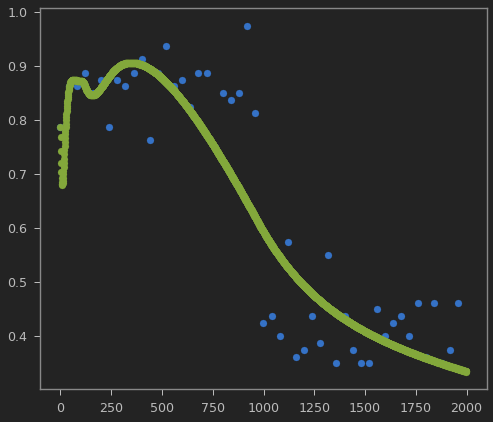

In [199]:
plt.scatter(x_reduced, p)
plt.scatter(x_axis, y_predicted)
plt.show

In [200]:
nr_splits = 50
genos = np.array(data_sorted['Geno'].to_list())
p_matrix = p_finder(genos, nr_splits)
x_axis = np.array(range(0, len(genos), 1))
x_reduced = x_axis[0:nr_splits]*(x_axis[-1]/nr_splits)

In [54]:
#q_pred_mat = polifit_model(x_reduced, p_matrix, x_axis)

In [55]:
#temp = np.array(q_pred_mat).T

In [56]:
#listy = temp.tolist()

In [57]:
#data_sorted['p_array'] = listy[0]

In [58]:
#data_sorted

In [59]:
#data_sorted.to_pickle("../../Data/Syn_tot_pcorrection.pkl")